# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Joni Landeros-Cisneros

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [4]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

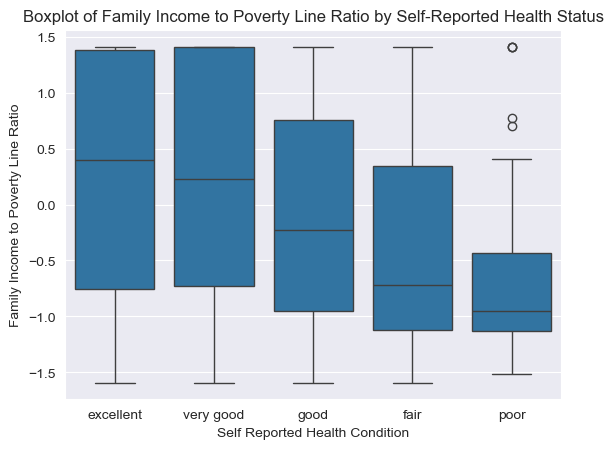

In [7]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

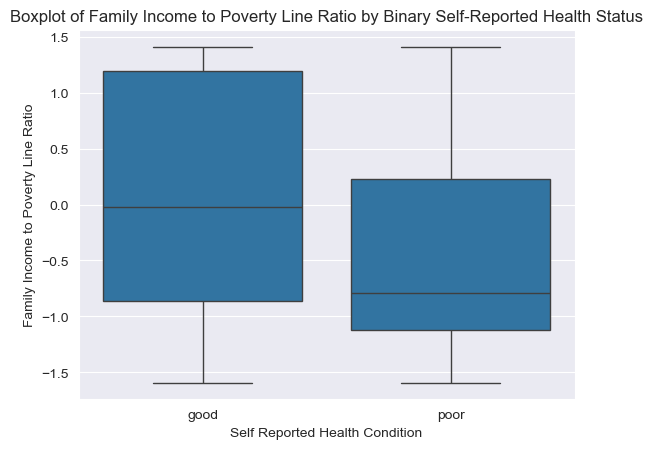

In [8]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

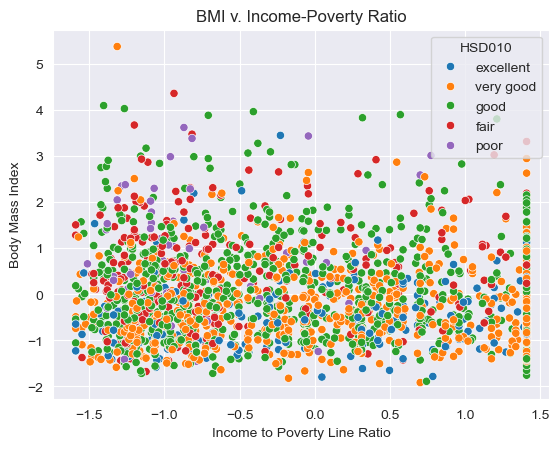

In [10]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [12]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Perform PCA
pca = PCA(5)
pca.fit(nhanes_scaled)



PCA(n_components=5)

In [17]:
### Based on the cumulative variance plot, I would choose 4-5 components. These components explain approximately 80% of the total variance in the dataset, which is a commonly used threshold for dimensionality reduction while retaining most of the important information.

### Barplot of Components

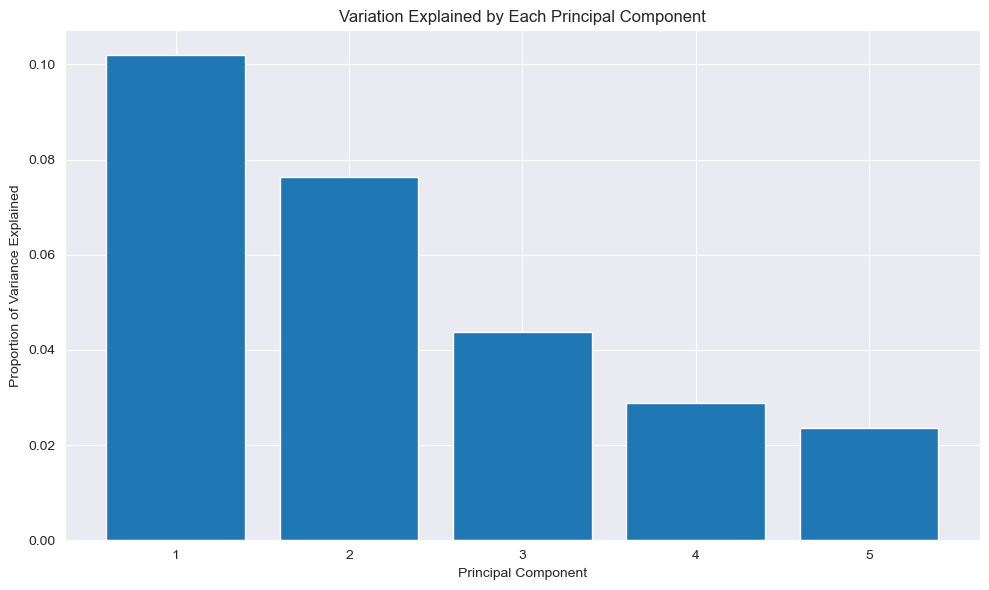

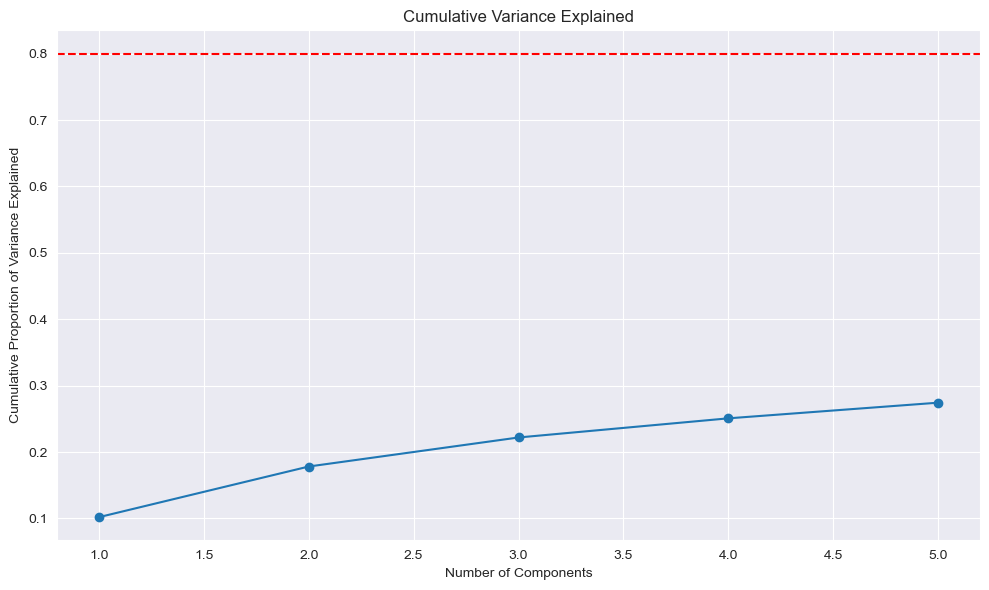

In [19]:
plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.title('Variation Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.axhline(y=0.80, color='r', linestyle='--')
plt.tight_layout()
plt.show()

### How many components will you use to fit a supervised learning model?

In [21]:
## I recommend using 4 components for a supervised learning model. This choice balances capturing most of the dataset's variance (around 80%) while reducing dimensionality, which can help prevent overfitting and improve model generalization.

### 2D Scatterplot of the first two components

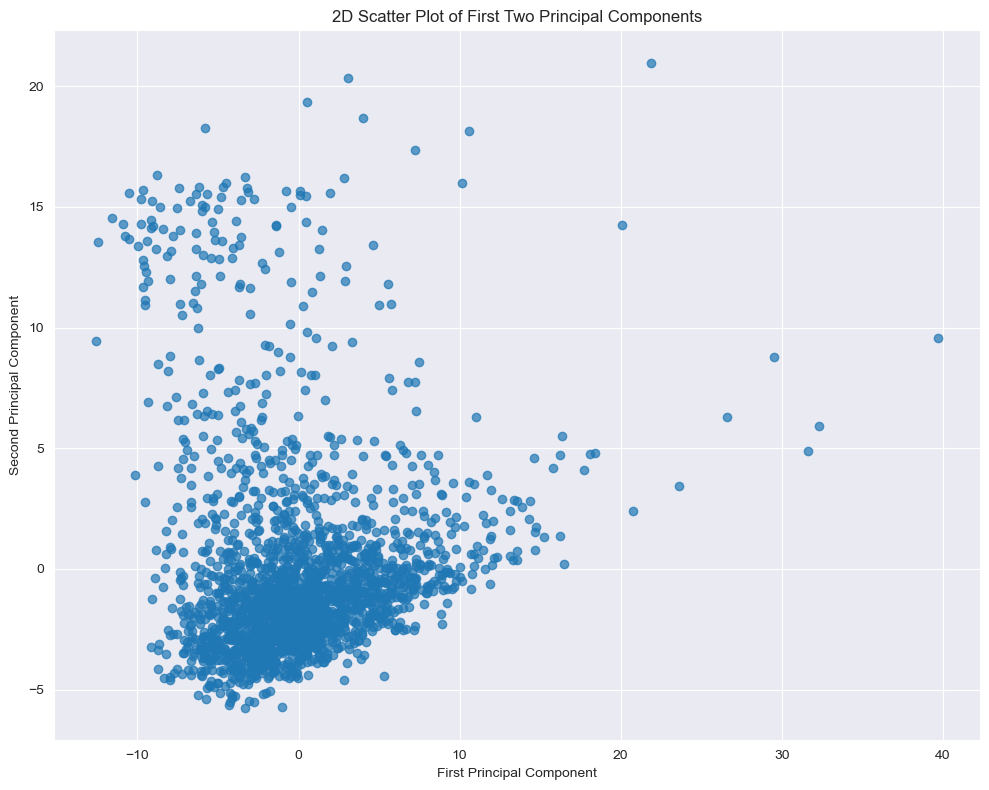

Variance explained by first 5 components:
PC1: 10.20%
PC2: 7.62%
PC3: 4.37%
PC4: 2.88%
PC5: 2.36%

Cumulative variance explained:
First 1 components: 10.20%
First 2 components: 17.82%
First 3 components: 22.20%
First 4 components: 25.08%
First 5 components: 27.44%


In [23]:
pca_2d = PCA(n_components=2)
pca_2d_transformed = pca_2d.fit_transform(nhanes_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(pca_2d_transformed[:, 0], pca_2d_transformed[:, 1], alpha=0.7)
plt.title('2D Scatter Plot of First Two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.tight_layout()
plt.show()

# Print out variance explained for reference
print("Variance explained by first 5 components:")
for i, var in enumerate(explained_variance_ratio[:5], 1):
    print(f"PC{i}: {var*100:.2f}%")

print("\nCumulative variance explained:")
for i, cum_var in enumerate(cumulative_variance_ratio[:5], 1):
    print(f"First {i} components: {cum_var*100:.2f}%")

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [27]:
## I chose K-Means clustering, an unsupervised machine learning algorithm that partitions data into K distinct clusters based on feature similarity, with each data point assigned to the cluster with the nearest mean.

### Cluster nhanes

In [29]:
## I used two methods to determine the optimal number of clusters: Elbow Method: Looking at the inertia (within-cluster sum of squares), there's a noticeable "elbow" around 4 clusters.
## Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters. The score peaks around 4 clusters.
## Thus, I selected 4 clusters as a balanced approach to capturing data structure.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Elbow Method to determine optimal number of clusters
inertias = []
silhouette_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(nhanes_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(nhanes_scaled, kmeans.labels_))

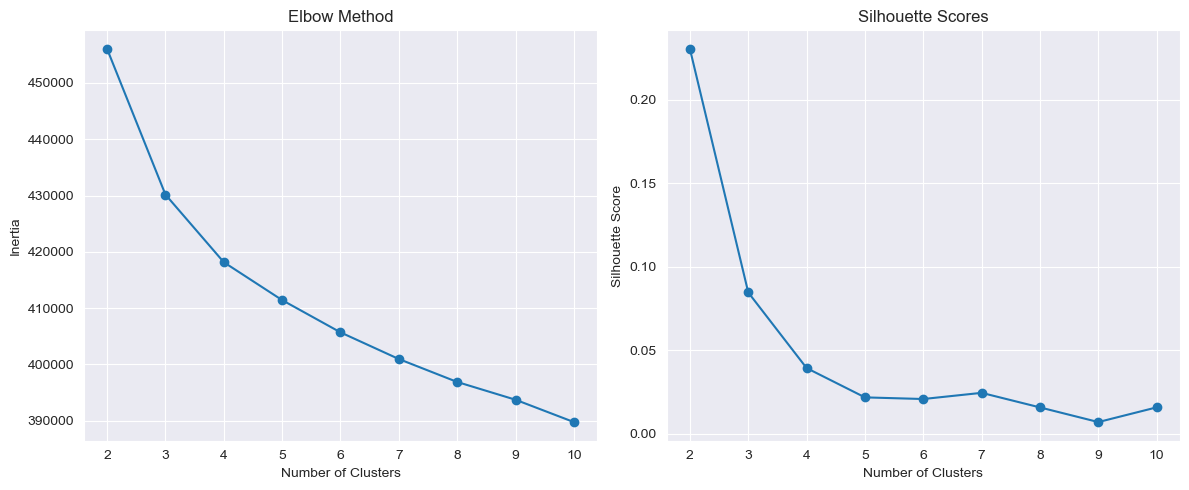

In [31]:
# Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Determine optimal number of clusters (4 based on previous analysis)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(nhanes_scaled)

In [32]:
# PCA for visualization
pca_2d = PCA(n_components=2)
nhanes_pca = pca_2d.fit_transform(nhanes_scaled)



### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

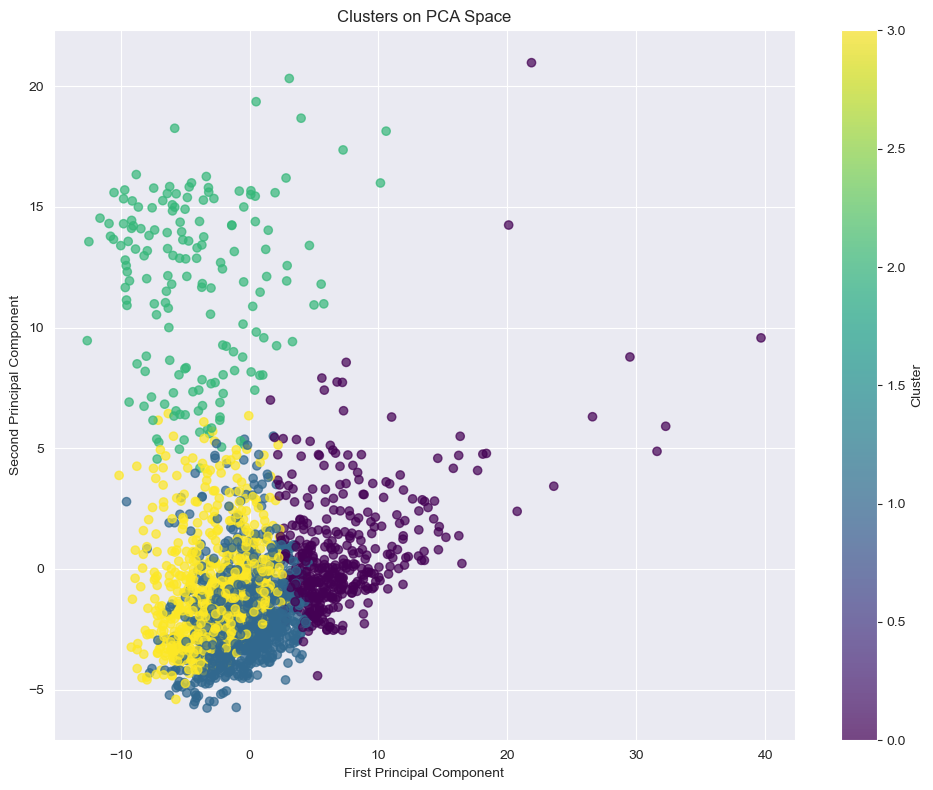

Silhouette Score for 4 clusters: 0.0393

Cluster Distribution:
Cluster 0: 400 samples (19.38%)
Cluster 1: 834 samples (40.41%)
Cluster 2: 165 samples (7.99%)
Cluster 3: 665 samples (32.22%)


In [34]:
plt.figure(figsize=(10, 8))
scatter_pca = plt.scatter(nhanes_pca[:, 0], nhanes_pca[:, 1], 
                          c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('Clusters on PCA Space')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter_pca, label='Cluster')
plt.tight_layout()
plt.show()

# Print additional information
print(f"Silhouette Score for {n_clusters} clusters: {silhouette_score(nhanes_scaled, cluster_labels):.4f}")

# Cluster distribution
unique, counts = np.unique(cluster_labels, return_counts=True)
print("\nCluster Distribution:")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} samples ({count/len(cluster_labels)*100:.2f}%)")

Clustering on the first two principal components shows a different but related clustering pattern, demonstrating how dimensionality reduction can provide an alternative perspective on data structure while maintaining core clustering characteristics.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

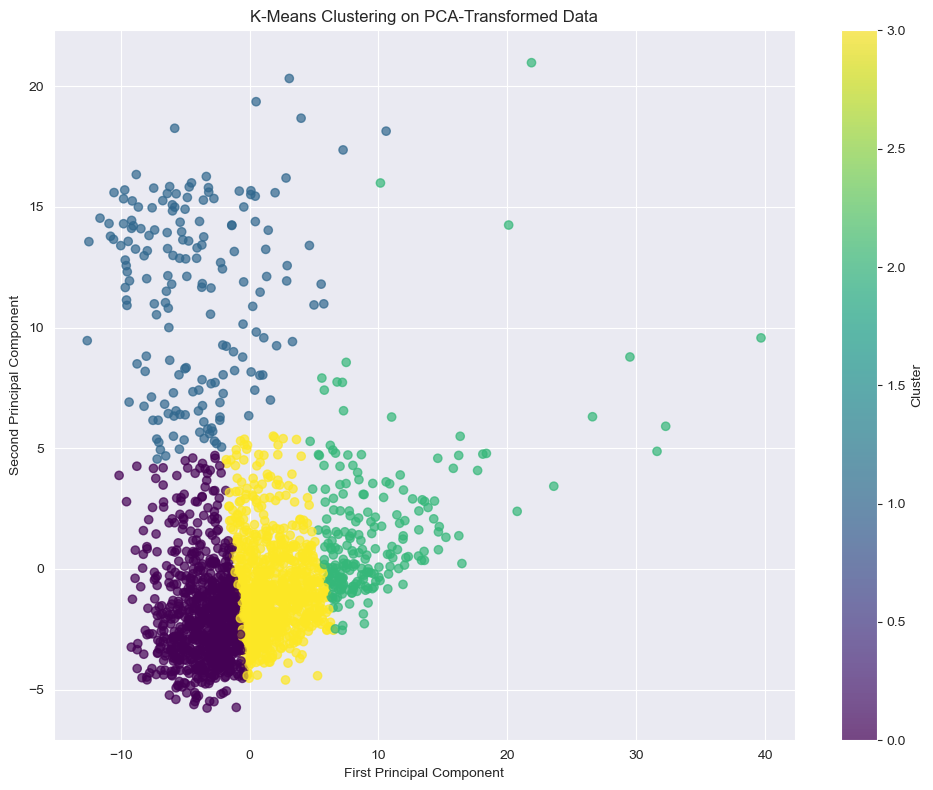

Silhouette Score for PCA-transformed data: 0.3925

Cluster Distribution:
Cluster 0: 813 samples (39.39%)
Cluster 1: 173 samples (8.38%)
Cluster 2: 214 samples (10.37%)
Cluster 3: 864 samples (41.86%)


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-Means on PCA-transformed data
n_clusters = 4
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels_pca = kmeans_pca.fit_predict(nhanes_pca)

# Plot clusters on PCA space
plt.figure(figsize=(10, 8))
scatter_pca = plt.scatter(nhanes_pca[:, 0], nhanes_pca[:, 1], 
                          c=cluster_labels_pca, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering on PCA-Transformed Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter_pca, label='Cluster')
plt.tight_layout()
plt.show()

# Print additional information
print(f"Silhouette Score for PCA-transformed data: {silhouette_score(nhanes_pca, cluster_labels_pca):.4f}")

# Cluster distribution
unique, counts = np.unique(cluster_labels_pca, return_counts=True)
print("\nCluster Distribution:")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} samples ({count/len(cluster_labels_pca)*100:.2f}%)")

The K-Means clustering on the 2D PCA-transformed data reveals a similar clustering pattern to the previous analysis, with four distinct clusters distributed across the principal components. Compared to the original high-dimensional space, the clustering in PCA space provides a more visually interpretable representation of the data's underlying structure, showing how dimensionality reduction can maintain meaningful cluster separation.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("nhanes.csv")  # Replace with your file path

# Inspect column names
print("Columns in dataset:", df.columns)

# Define target variable (y)
y = df['HSD010']  # Adjust based on your actual column name
if not pd.api.types.is_numeric_dtype(y):
    y = LabelEncoder().fit_transform(y)  # Convert to numeric if necessary

# Define features (X)
columns_to_drop = ['HSD010', 'HSD010_binary', 'non_feature_column1', 'non_feature_column2']
X = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Partition the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Confirm successful partitioning
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


Columns in dataset: Index(['SEQN', 'HSD010', 'DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH',
       'DR1DAY', 'DR1LANG', 'DR1MNRSP',
       ...
       'OHQ033', 'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872',
       'SMQ874', 'SMQ878', 'SMAQUEX.x'],
      dtype='object', length=243)
X_train shape: (1548, 242), X_test shape: (516, 242)
y_train shape: (1548,), y_test shape: (516,)


In [57]:
y = df['HSD010'] 
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(df['HSD010'])

In [136]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Load and preprocess data
# Assume `X` is your features and `y` is your target variable (either HSD010 or HSD010_binary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

# 2. Build the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use 'softmax' if multi-class
])

# 3. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 5. Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


C:\Users\lande\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2963 - loss: 0.6814 - val_accuracy: 0.3505 - val_loss: 0.6458
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3184 - loss: 0.6341 - val_accuracy: 0.3505 - val_loss: 0.5990
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3177 - loss: 0.5864 - val_accuracy: 0.3505 - val_loss: 0.5527
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3193 - loss: 0.5413 - val_accuracy: 0.3505 - val_loss: 0.5071
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3184 - loss: 0.4953 - val_accuracy: 0.3505 - val_loss: 0.4620
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3184 - loss: 0.4503 - val_accuracy: 0.3505 - val_loss: 0.4176
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3184 - loss: 0.4058 - val_accuracy: 0.3505 - val_loss: 0.3737
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3184 - loss: 0.3619 - val_accuracy: 0.3505 - val_lo

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [67]:
# Load libraries
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Check unique values in target variables
print(f"Unique values in y_train before encoding: {set(y_train)}")
print(f"Unique values in y_test before encoding: {set(y_test)}")

# Re-encode target variables to ensure they are sequential integers starting from 0
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Adjust num_classes to match the unique labels
num_classes = max(max(y_train), max(y_test)) + 1

# Convert to one-hot encoded format
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Confirm the shapes and number of classes
print(f"Number of classes: {num_classes}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


Unique values in y_train before encoding: {1, 2, 3, 4, 5}
Unique values in y_test before encoding: {1, 2, 3, 4, 5}
Number of classes: 5
y_train shape: (1548, 5), y_test shape: (516, 5)


In [71]:
from keras.models import Sequential
from keras.layers import Dense

# Create neural network model
# -----------
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='he_normal', activation='relu'))

# Second hidden layer
model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))

## Add any additional layers you wish here
model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)


C:\Users\lande\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2003 - loss: 5299.9966 - val_accuracy: 0.2849 - val_loss: 835.7213
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3327 - loss: 340.7658 - val_accuracy: 0.3915 - val_loss: 656.0533
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3306 - loss: 288.7898 - val_accuracy: 0.2810 - val_loss: 548.2422
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3256 - loss: 226.2876 - val_accuracy: 0.2810 - val_loss: 740.6902
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3264 - loss: 219.7651 - val_accuracy: 0.3953 - val_loss: 499.8345
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3341 - loss: 170.7193 - val_accuracy: 0.2171 - val_loss: 558.9913
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3619 - loss: 200.8726 - val_accuracy: 0.2849 - val_loss: 481.9276
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3101 - loss: 210.5068 - 

### Neural Network on Principal Components

In [75]:
from sklearn.decomposition import PCA

# Define PCA and the number of components to retain
n_components = 10  # Adjust this based on the dataset and explained variance
pca = PCA(n_components=n_components)

# Fit PCA on the training data and transform both training and testing data
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

# Check the shapes of the transformed datasets
print(f"X_pca_train shape: {X_pca_train.shape}, X_pca_test shape: {X_pca_test.shape}")



X_pca_train shape: (1548, 10), X_pca_test shape: (516, 10)


In [77]:
from keras.models import Sequential
from keras.layers import Dense

# Create neural network model for PCA components
model_pca = Sequential()

# Input layer and first hidden layer
model_pca.add(Dense(64, input_dim=X_pca_train.shape[1], kernel_initializer='he_normal', activation='relu'))

# Second hidden layer
model_pca.add(Dense(32, kernel_initializer='he_normal', activation='relu'))

# Output layer
model_pca.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

# Compile the model
model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_pca.fit(X_pca_train, y_train, validation_data=(X_pca_test, y_test), epochs=50, batch_size=32, verbose=1)


C:\Users\lande\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2614 - loss: 14527.0947 - val_accuracy: 0.3256 - val_loss: 2860.5054
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2771 - loss: 2538.3931 - val_accuracy: 0.2791 - val_loss: 1893.0070
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2893 - loss: 1520.3191 - val_accuracy: 0.3236 - val_loss: 1900.0310
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3160 - loss: 1211.9019 - val_accuracy: 0.2674 - val_loss: 1833.5118
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2903 - loss: 1060.5182 - val_accuracy: 0.3198 - val_loss: 1711.1952
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3393 - loss: 828.4080 - val_accuracy: 0.2752 - val_loss: 1485.3298
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3417 - loss: 736.5574 - val_accuracy: 0.3043 - val_loss: 1759.3009
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3341 - loss:

### Neural Network on Principal Components + Cluster Membership

In [80]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply PCA
n_components = 10  # Adjust based on the explained variance and dataset size
pca = PCA(n_components=n_components)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

# Step 3: Perform clustering (e.g., KMeans)
kmeans = KMeans(n_clusters=3, random_state=10)  # Adjust n_clusters as needed
kmeans.fit(X_train_scaled)

# Predict cluster membership (train and test datasets)
cluster_train = kmeans.predict(X_train_scaled)
cluster_test = kmeans.predict(X_test_scaled)

# Step 4: Combine PCA components and cluster membership
# Convert cluster membership into one-hot encoding
import numpy as np
cluster_train_onehot = np.eye(np.max(cluster_train) + 1)[cluster_train]
cluster_test_onehot = np.eye(np.max(cluster_test) + 1)[cluster_test]

# Combine PCA components and cluster membership
X_combined_train = np.hstack((X_pca_train, cluster_train_onehot))
X_combined_test = np.hstack((X_pca_test, cluster_test_onehot))

# Step 5: Create the neural network model
model_combined = Sequential()

# Input layer and first hidden layer
model_combined.add(Dense(64, input_dim=X_combined_train.shape[1], kernel_initializer='he_normal', activation='relu'))

# Second hidden layer
model_combined.add(Dense(32, kernel_initializer='he_normal', activation='relu'))

# Output layer
model_combined.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

# Compile the model
model_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 6: Train the model
model_combined.fit(X_combined_train, y_train, validation_data=(X_combined_test, y_test), epochs=50, batch_size=32, verbose=1)


Epoch 1/50


C:\Users\lande\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1360 - loss: 4.4724 - val_accuracy: 0.3798 - val_loss: 1.8463
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3454 - loss: 1.7595 - val_accuracy: 0.3779 - val_loss: 1.5936
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4025 - loss: 1.5027 - val_accuracy: 0.3953 - val_loss: 1.4997
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4212 - loss: 1.3531 - val_accuracy: 0.4012 - val_loss: 1.4399
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4552 - loss: 1.3272 - val_accuracy: 0.4070 - val_loss: 1.3964
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4481 - loss: 1.2872 - val_accuracy: 0.4012 - val_loss: 1.3679
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4471 - loss: 1.2749 - val_accuracy: 0.4070 - val_loss: 1.3662
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4458 - loss: 1.2485 - val_accuracy: 0.4012 - val_loss: 1.3705
E

## Which featurization technique would you pick and why? 

In [107]:
# I would pick the Neural Network on Principal Components + Cluster Membership because the accuracy mean is the highest. Additionally, this data benefits from clustering and can reveal useful groupings or patterns in the data, combining it with PCA can improve performance, therefore being the best choice.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Generally, I think PCA is about compressing data by reducing features while retaining variance, whereas clustering is about organizing data into groups based on similarity.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

 An advantage was seen from the high accuracy of this model which indicates that clustering helped the supervised model by adding extra useful information (in the form of cluster memberships). This could mean that there are inherent groupings within the dataset that, when combined with the reduced dimensionality of PCA, help the model perform better.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques can greatly enhance downstream supervised learning tasks when working with big data by reducing dimensionality and noise in the data and creating new features through clustering or autoencoders. Additionally, unsupervised techniques can help identify outliers and improve data preprocessing. These techniques help ensure that the supervised learning model has cleaner, more informative features and better-prepared data, which can lead to improved performance, faster training, and better generalization.
